# Unveiling the Cost and Characteristics of Used Car Prices: A Web Data Scraping Journey on Standvirtual

## Motivation

The automotive market is a dynamic ecosystem where myriad factors influence the pricing and characteristics of used cars. Understanding these intricacies is crucial for buyers, sellers, and analysts alike. With this motivation in mind, our project sets out to delve into the realm of used car prices, seeking to uncover patterns, trends, and insights that shape this ever-evolving landscape.

Standvirtual, a prominent online platform for buying and selling vehicles, offers a rich repository of data ripe for exploration. By harnessing the power of web data scraping, we aim to extract valuable information from Standvirtual listings, focusing on key features such as ad titles, prices, fuel types, mileage, and more. This endeavor is driven by a desire to empower stakeholders with actionable insights, enabling informed decision-making and facilitating a deeper understanding of the nuances within the used car market.

## Objectives

Our project is guided by a set of clear objectives aimed at illuminating the intricacies of used car prices and characteristics. These objectives serve as beacons, directing our efforts towards meaningful outcomes and actionable insights:

1. **Comprehensive Data Collection**: Our foremost objective is to gather a comprehensive dataset encompassing a wide range of listings from Standvirtual. This includes extracting details such as ad titles, prices, fuel types, mileage, year of manufacture, transmission types, engine sizes, and other relevant features.

2. **Analysis of Pricing Dynamics**: With pricing being a central concern for buyers and sellers, we seek to analyze the dynamics behind used car prices. By examining trends, outliers, and correlations within the dataset, we aim to identify factors that influence pricing decisions, such as mileage, age, and vehicle specifications.

3. **Characterization of Vehicle Features**: Beyond pricing, we aim to characterize the features and specifications of listed vehicles. This involves analyzing attributes like fuel type, transmission, engine size, and mileage to gain insights into the diversity and preferences within the used car market.

4. **Identification of Trends and Patterns**: Through rigorous analysis, we aim to identify trends and patterns within the dataset. This includes uncovering seasonal variations, regional preferences, and shifts in consumer demand that may impact the pricing and availability of used cars.

5. **Empowering Stakeholders with Insights**: Ultimately, our objective is to empower stakeholders with actionable insights derived from our analysis. Whether it's aiding buyers in making informed purchasing decisions, assisting sellers in pricing their vehicles competitively, or providing researchers with valuable data for further study, our goal is to add tangible value to the automotive ecosystem.

## Data Scraping

To achieve our objectives, we employ web data scraping techniques to extract pertinent information from Standvirtual listings. This involves the systematic retrieval of data from the platform's web pages, focusing on key attributes relevant to our analysis.

Using specialized tools and scripts, we crawl through Standvirtual's listings, capturing details such as ad titles, prices, fuel types, mileage, and other specified features. By adhering to ethical scraping practices and respecting the platform's terms of service, we ensure the integrity and legality of our data collection process.

Once the data is collected, we preprocess and organize it into a structured dataset suitable for analysis. This involves cleaning and validating the extracted information, resolving inconsistencies, and standardizing formats to facilitate meaningful insights.

Through this meticulous data scraping process, we lay the foundation for our analysis, enabling us to delve deep into the world of used car prices and characteristics on Standvirtual. With roughly 1410 ad web pages on the website, each containing 32 ads, we expect to scrape the data of 45120 used cars.

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import logging

# Create and configure logger
logging.basicConfig(
	filename = "debug.log",
	format = "%(asctime)s [%(levelname)s] %(message)s",
	filemode = 'w')

# Create a custom logger to prevent debugging info from imported modules
logger = logging.getLogger(__name__)

# Setting the threshold of logger to DEBUG
logger.setLevel(logging.DEBUG)

# Create an empty list to hold the data
data = []

# Loop over all the pages in the website
for page in range(1420):

	# Create the url for each page
	url = 'https://www.standvirtual.com/carros/usados?page={}'.format(page)

	# Get the page contents
	r = requests.get(url)

	# Scrape the page contents
	soup = BeautifulSoup(r.content, 'html.parser')

	# Find the ads
	ads = soup.find_all("article", {"class": "ooa-yca59n eszxync0"})

	# Loop through each ad to scrape the relevant data
	for i, ad in enumerate(ads):

		# Give a summary of the ads found in each page
		print(f'Page: {page} - ad found: {i}/{len(ads)}', end='\r')

		try:
			# Get the ad attributes
			title = ad.find("h1", {"class": "eszxync9 ooa-1ed90th er34gjf0"}).text
			cc_hp = ad.find("p", {"class": "eszxync10 ooa-1tku07r er34gjf0"}).text
			kms, fuel, gear, year = [attr.text for attr in ad.find_all("dd", {"class": "ooa-1omlbtp eszxync13"})]
			loc = ad.find("dd", {"class": "ooa-1jb4k0u eszxync15"}).text
			price = ad.find("h3", {"class": "eszxync16 ooa-1n2paoq er34gjf0"}).text

			# Append the attributes to the data list as a dictionary 
			data.append({
				'TITLE': title,
				'CC_HP': cc_hp,
				'KMS': kms,
				'FUEL': fuel,
				'GEAR': gear,
				'YEAR': year,
				'LOC': loc,
				'PRICE': price,
			})

			# Write to the logger
			logger.info(f'Sucessfully scraped page: {page} - ad found: {i}/{len(ads)}')

		except Exception as err:
			logger.error(f'Failed to scrape page: {page} - ad found: {i}/{len(ads)}')

# Save the data to an excel file
df = pd.DataFrame(data)
df.to_excel('data/RAW_DATA.xlsx', index=False)

## Data Cleaning: Unveiling Clarity from Complexity

With the culmination of the data scraping phase, our journey into understanding the intricacies of used car prices on Standvirtual progresses into the pivotal realm of data cleaning. This critical stage serves as the bridge between raw, unstructured data and insightful analysis, where we meticulously refine and prepare the dataset for meaningful interpretation and exploration.

**Removing Duplicates:**

Our first task in the data cleaning process is to identify and remove duplicate entries within the dataset. Duplicates may arise due to various reasons such as multiple listings of the same vehicle or errors during the scraping process. By systematically detecting and eliminating duplicate records, we ensure the integrity and accuracy of our dataset, preventing skewness in subsequent analysis.

**Parsing Composite Strings:**

Many attributes within the dataset may be represented as composite strings, encapsulating multiple pieces of information within a single field. For instance, ad titles may contain both the make and model of the vehicle. To unlock the full potential of such attributes and facilitate granular analysis, we parse these composite strings into distinct fields, allowing for more nuanced insights into the characteristics of each listing.

**Removing Special Characters:**

Special characters scattered throughout the dataset can hinder readability and compatibility with analytical tools. Therefore, we undertake the task of cleansing the dataset by removing extraneous special characters, ensuring uniformity and consistency in the representation of textual data.

**Defining Adequate Data Types:**

To optimize storage efficiency and facilitate accurate analysis, it is imperative to define appropriate data types for each attribute within the dataset. Numeric values such as prices and mileage should be represented as integers or floats, while categorical variables like fuel type and transmission should be encoded as strings or categorical data types. By aligning data types with the nature of the underlying information, we enhance the efficiency and efficacy of subsequent analytical processes.

**Handling NaN Values:**

Missing or null values, denoted as NaN (Not a Number), are common occurrences within real-world datasets and must be carefully addressed to prevent bias and distortion in analysis. We employ various strategies such as imputation, interpolation, or exclusion to handle NaN values appropriately, ensuring that our analysis is based on complete and reliable information.

**Removing Obsolete Columns:**

As our understanding of the dataset evolves, certain attributes may emerge as redundant or irrelevant to our analytical objectives. In such cases, we judiciously remove obsolete columns, streamlining the dataset and focusing our attention on the most salient features and characteristics of used car listings.

Through these meticulous steps of data cleaning, we transform raw data into a refined and coherent dataset, primed for in-depth analysis and insightful interpretation. By upholding the principles of data integrity and rigor, we pave the way for meaningful discoveries and actionable insights into the dynamic world of used car prices on Standvirtual.

In [25]:
import pandas as pd
import numpy as np

# Import the data
df = pd.read_excel('data/RAW_DATA.xlsx', nrows=100000)
raw_length = len(df)

# Start by removing duplicates
df = df.drop_duplicates()
unique_length = len(df)
print(f'Duplicate removal shrink factor: {unique_length/raw_length:.0%}')

# Clean the kilometers and price columns
df['KMS'] = df['KMS'].str.replace('km| ', '', regex=True).astype(int)
df['PRICE'] = df['PRICE'].str.replace(' ', '').astype(int)

# Get the cubic centimeters and the horsepower
df['CC'] = None
df['HP'] = None
for index, row in df.iterrows():
    res = row['CC_HP'].split(' • ')
    if len(res) == 2:
        cc, hp = res
        df.loc[index, 'CC'] = cc.replace('cm3', '').replace(' ', '')
        df.loc[index, 'HP'] = hp.replace('cv', '').replace(' ', '')
    elif res[0].endswith(' cv'):
        df.loc[index, 'CC'] = None
        df.loc[index, 'HP'] = res[0].replace('cv', '').replace(' ', '')
    elif res[0].endswith('cm3'):
        df.loc[index, 'CC'] = res[0].replace('cm3', '').replace(' ', '')
        df.loc[index, 'HP'] = None
df['CC'] = df['CC'].fillna(np.nan).astype('Int64')
df['HP'] = df['HP'].astype(int)

# Alternatively, use regular expressions
# df['CC'] = df['CC_HP'].str.extract('^(.*) cm3')
# df['CC'] = df['CC'].str.replace(' ', '')
# df['HP'] = df['CC_HP'].str.extract('(.*) cv')
# df['HP'] = df['HP'].str.replace(' ', '')

# Use regular expressions to extract the district from the location
df['DISTRICT'] = df['LOC'].str.extract('\(([^()]*)\)$')
# df['DISTRICT'] = None
# for index, row in df.iterrows():
#     res = row['LOC'].split('(')
#     df.loc[index, 'DISTRICT'] = res[-1].replace(')', '')

# Add a hyphen to some brands to correctly parse them
df['TITLE'] = df['TITLE'].str.replace('Alfa Romeo', 'Alfa-Romeo')
df['TITLE'] = df['TITLE'].str.replace('Aston Martin', 'Aston-Martin')
df['TITLE'] = df['TITLE'].str.replace('Land Rover', 'Land-Rover')
df['TITLE'] = df['TITLE'].str.replace('Rolls Royce', 'Rolls-Royce')

# Parse the brand and model
df['BRAND'] = df['TITLE'].str.split().str.get(0)
df['MODEL'] = df['TITLE'].str.split().str.get(1)

# Drop undesired columns
df = df.drop(columns=['CC_HP', 'TITLE', 'LOC'])

# Drop NA rows
# df = df.dropna()

# Print the first five rows
print(df.head())

# Save to excel
df.to_excel('data/CLEAN_DATA.xlsx', index=False)

Duplicate removal shrink factor: 35%
      KMS      FUEL    GEAR  YEAR  PRICE    CC   HP         DISTRICT   BRAND  \
0  135000  Gasolina  Manual  2009  12500  1400  136            Porto  Abarth   
1  159000  Gasolina  Manual  2008  14450  1368  140  Ilha da Madeira  Abarth   
2  149000  Gasolina  Manual  2009  11990  1368  140          Setúbal  Abarth   
3   82361  Gasolina  Manual  2010  13900  1368  135             Faro  Abarth   
4  136000  Gasolina  Manual  2011  12999  1368  135            Braga  Abarth   

  MODEL  
0   500  
1   500  
2   500  
3   500  
4   500  


## Exploratory Data Analysis: Unveiling Insights into Used Car Market Dynamics

As we embark on the next phase of our journey into understanding the nuances of the used car market on Standvirtual, we turn our attention towards exploratory data analysis (EDA). This crucial step serves as a lens through which we glean insights, uncover patterns, and unearth trends hidden within our meticulously curated dataset.

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the clean data
df = pd.read_excel('data/CLEAN_DATA.xlsx')

**Most Popular Car Brands and Models:**

One of the central questions driving our analysis is the identification of the most popular car brands and their corresponding models within the Standvirtual listings. By aggregating and analyzing the frequency of occurrence for each brand and model, we gain valuable insights into consumer preferences and market dominance.

<AxesSubplot: xlabel='count', ylabel='BRAND'>

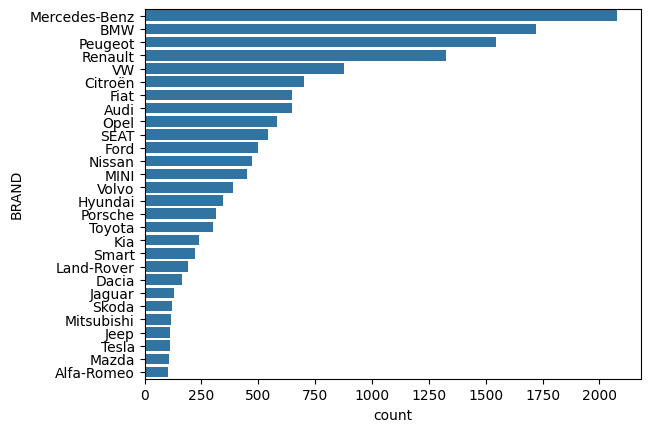

In [11]:
df_filter = df[df['BRAND'].map(df['BRAND'].value_counts()) > 100]

sns.countplot(
    data = df_filter, 
    order = df_filter['BRAND'].value_counts().index,
    y='BRAND')

**Average Cost per Brand (Model Agnostic):**

Beyond popularity, understanding the pricing dynamics across different car brands is paramount. By calculating the average cost per brand, irrespective of specific models, we gain a broad perspective on the pricing hierarchy within the used car market. This analysis provides stakeholders with valuable insights into the relative affordability and perceived value of various automotive brands.

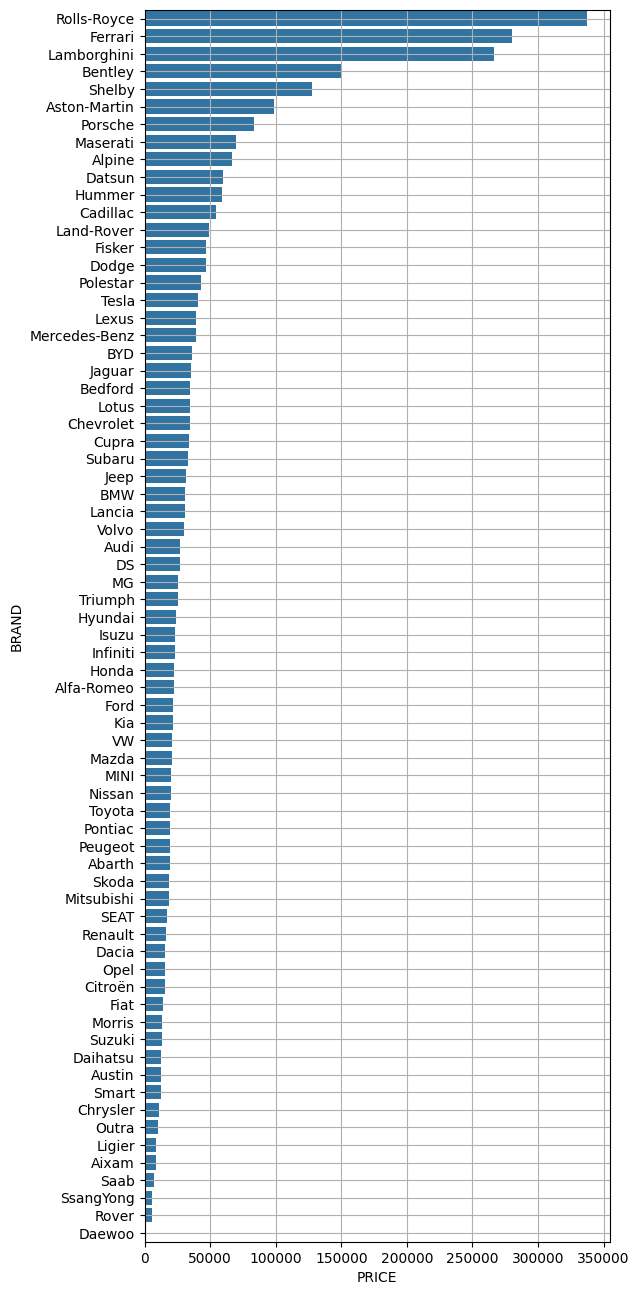

In [12]:
df_pvt = pd.pivot_table(df, values='PRICE', index='BRAND', aggfunc='mean').sort_values('PRICE', ascending=False)
plt.figure(figsize=(6, 16))
g = sns.barplot(y=df_pvt.index, x="PRICE", data=df_pvt)
g.grid()

**Districts with the Most Ads:**

Geographical factors play a significant role in shaping market dynamics, and our analysis extends to identifying the districts in Portugal with the highest concentration of Standvirtual listings. By mapping the distribution of ads across different regions, we uncover hotspots of activity and potential areas of interest for both buyers and sellers.

<AxesSubplot: xlabel='count', ylabel='DISTRICT'>

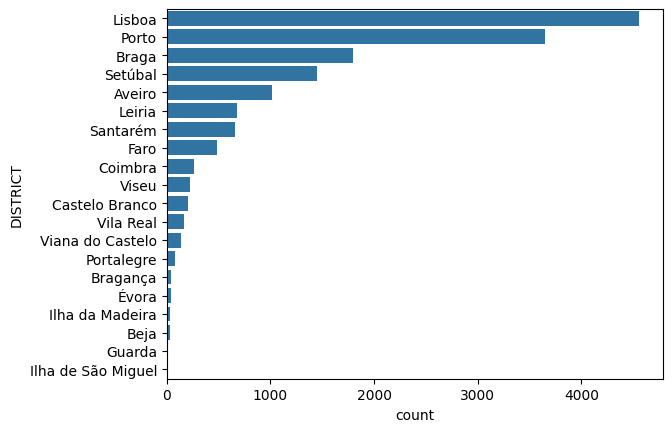

In [13]:
sns.countplot(data = df, order = df_filter['DISTRICT'].value_counts().index, y='DISTRICT')

**Average Used Car Cost per District:**

Building upon our geographical analysis, we delve deeper into understanding pricing variations across different districts in Portugal. By calculating the average cost of used cars within each district, we illuminate regional disparities in pricing and provide stakeholders with localized insights to inform their decision-making processes.

<AxesSubplot: xlabel='PRICE', ylabel='DISTRICT'>

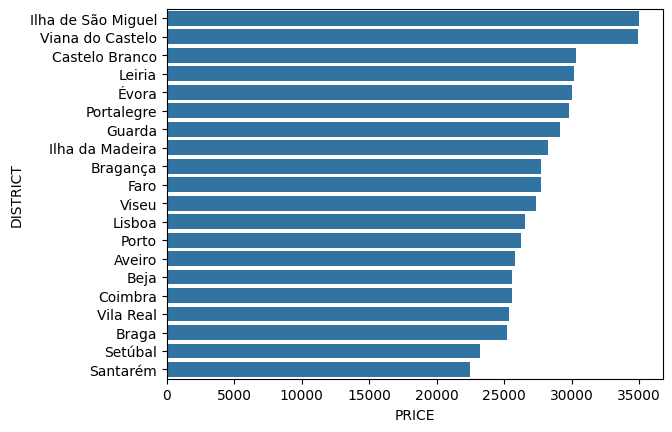

In [14]:
df_pvt = pd.pivot_table(df, values='PRICE', index='DISTRICT', aggfunc='mean').sort_values('PRICE', ascending=False)
sns.barplot(y=df_pvt.index, x="PRICE", data=df_pvt)

**Average Mileage per Fuel Type**

Fuel type is a crucial determinant of both operating costs and environmental impact, and our analysis includes a comparative examination of the average mileage for different fuel types. By quantifying and comparing the mileage of vehicles powered by gasoline, diesel, electric, or hybrid systems, we shed light on the efficiency and longevity of each propulsion system, offering valuable insights for prospective buyers and industry observers alike.

<AxesSubplot: xlabel='KMS', ylabel='FUEL'>

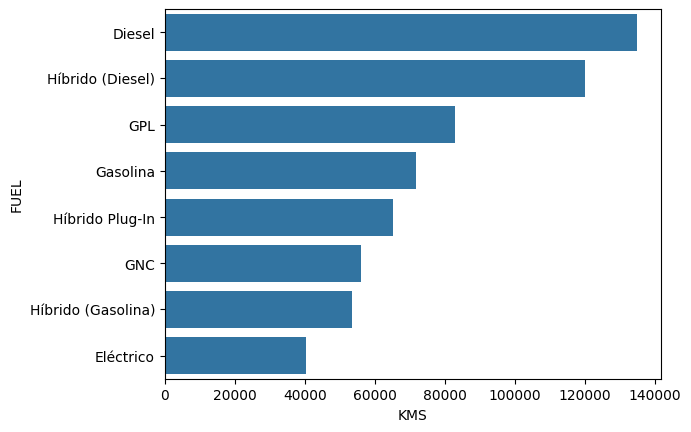

In [15]:
df_pvt = pd.pivot_table(df, values='KMS', index='FUEL', aggfunc='mean').sort_values('KMS', ascending=False)
sns.barplot(y=df_pvt.index, x="KMS", data=df_pvt)

**Average Cost per Fuel Type**

Another pertinent aspect of our analysis involves examining the average cost of used cars based on their fuel type. By aggregating pricing data and categorizing it according to fuel type (gasoline, diesel, electric, hybrid), we gain insights into the cost implications associated with different propulsion systems. This analysis provides stakeholders with valuable information regarding the affordability and market demand for vehicles based on their fuel type.

<AxesSubplot: xlabel='PRICE', ylabel='FUEL'>

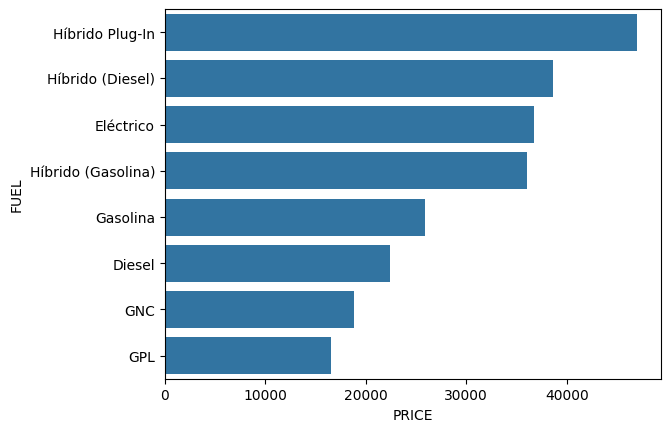

In [16]:
df_pvt = pd.pivot_table(df, values='PRICE', index='FUEL', aggfunc='mean').sort_values('PRICE', ascending=False)
sns.barplot(y=df_pvt.index, x="PRICE", data=df_pvt)

**Number of Ads per Fuel Type**

Understanding the distribution of listings across different fuel types is essential for comprehensively assessing market demand and preferences. By counting the number of ads for each fuel type (gasoline, diesel, electric, hybrid), we gain insights into the popularity and availability of vehicles powered by different propulsion systems. This analysis provides stakeholders with a holistic view of market trends and consumer behavior regarding fuel type preferences.

<AxesSubplot: xlabel='count', ylabel='FUEL'>

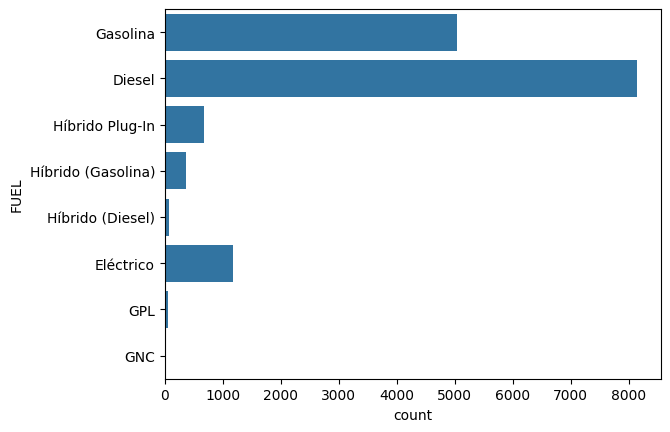

In [28]:
sns.countplot(data=df, y='FUEL')

## Price prediction

comments



In [61]:
import pandas as pd
from scipy import stats 
import seaborn as sns

df = pd.read_excel('data/CLEAN_DATA.xlsx')
print(df.shape)
df.drop(columns=['CC', 'DISTRICT', 'MODEL'], inplace=True)
df.dropna(inplace=True)
df.replace({
    'FUEL':{
        'Híbrido Plug-In': 'Híbrido',
        'Híbrido (Gasolina)': 'Híbrido',
        'Híbrido (Diesel)': 'Híbrido',
        }
}, inplace=True)
df = df[~df['FUEL'].isin(['GPL', 'GNC'])]
df = df[df['BRAND'].map(df['BRAND'].value_counts()) > 100]

df = df[stats.zscore(df['PRICE']) < 3]
df = df[stats.zscore(df['HP']) < 3]
df = df[stats.zscore(df['KMS']) < 3]

#the most expensive cars in the collection
df.nlargest(5, 'PRICE')

#cars with the most miles travelled in the collection
df.nlargest(5, 'KMS')

#oldest cars in the collection
df.nsmallest(5, 'YEAR')

#numbers of cars under the various car manufacturers
df['BRAND'].value_counts()

#count of the manufacture years 
df['YEAR'].value_counts()

print(df.shape)
df.info()


(15532, 10)
(14252, 7)
<class 'pandas.core.frame.DataFrame'>
Index: 14252 entries, 34 to 15531
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   KMS     14252 non-null  int64 
 1   FUEL    14252 non-null  object
 2   GEAR    14252 non-null  object
 3   YEAR    14252 non-null  int64 
 4   PRICE   14252 non-null  int64 
 5   HP      14252 non-null  int64 
 6   BRAND   14252 non-null  object
dtypes: int64(4), object(3)
memory usage: 890.8+ KB


Comments

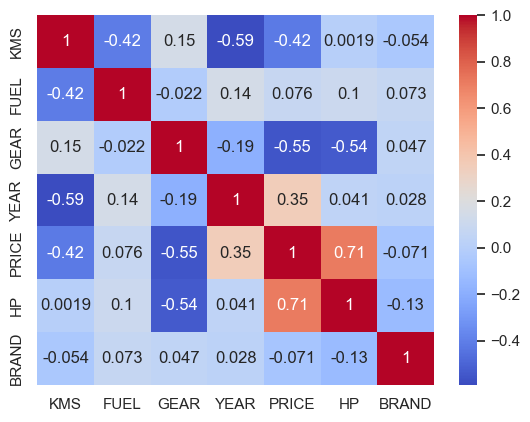

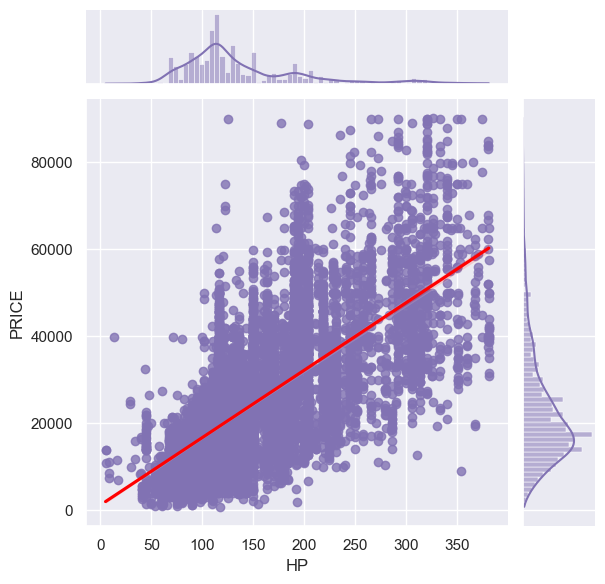

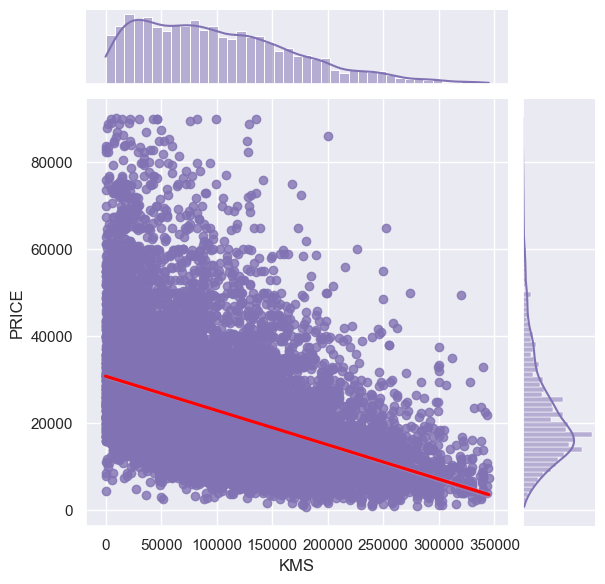

           Name  Train_Score  R_squared  Mean_absolute_error  \
3      rf_model     0.984598   0.879046             0.133919   
2  extree_model     0.999675   0.873156             0.136722   
0  linear_model     0.766660   0.759298             0.198365   
1   ridge_model     0.766643   0.759177             0.198570   

   Root_mean_sqd_error  
3             0.194218  
2             0.198890  
0             0.273980  
1             0.274048  


In [60]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_squared_error
from sklearn import metrics

# https://python.plainenglish.io/car-price-prediction-with-machine-learning-in-python-portfolio-project-11f57812a1b
# https://www.zenrows.com/blog/car-price-prediction-in-python#linear-model-from-sklearn

# label encode the categorical values
le_manufacturer = LabelEncoder()
le_engine = LabelEncoder()
le_transmission = LabelEncoder()

df['FUEL'] = le_manufacturer.fit_transform(df['FUEL'])
df['GEAR'] = le_engine.fit_transform(df['GEAR'])
df['BRAND'] = le_transmission.fit_transform(df['BRAND'])

sns.heatmap(df.corr(), annot=True, cmap='coolwarm') 
plt.show() 

sns.set_theme(style="darkgrid") 
sns.jointplot(x="HP", y="PRICE", data=df, 
	kind="reg", color="m", line_kws={'color': 'red'}) 
plt.show()

sns.set_theme(style="darkgrid") 
sns.jointplot(x="KMS", y="PRICE", data=df, 
	kind="reg", color="m", line_kws={'color': 'red'}) 
plt.show()

# creating X and y variables
X = df.drop('PRICE', axis=1)

# log transform the price column
y = np.log(df['PRICE'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# feature scale the X_train and X_test values
norm = MinMaxScaler().fit(X_train)

#transform training data
X_train = norm.transform(X_train)

#transform testing data
X_test = norm.transform(X_test)

models = {
    'linear_model': LinearRegression(),
    'ridge_model': Ridge(random_state=123),
    'extree_model':ExtraTreesRegressor(random_state = 123),
    'rf_model' : RandomForestRegressor(random_state = 123)
}

def train_model(models: dict) -> pd.DataFrame:
    """
It takes a dictionary containing a key pair of model names and estimators.
    It returns a data frame containing the metrics of the trained model.
    """
    my_dict = {}
    name_list, train_score_list, r_sqd_list, mae_list, rmse_list = [], [], [], [], []
    for name, estimator in models.items():
        # fit
        estimator.fit(X_train, y_train)

        # make predictions
        y_pred = estimator.predict(X_test)

        # metrics
        train_score = estimator.score(X_train, y_train)
        r_sqd = metrics.r2_score(y_test, y_pred)
        mae = metrics.mean_absolute_error(y_test, y_pred)
        mse = metrics.mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)

        # add the metrics to the empty list
        name_list.append(name)
        train_score_list.append(train_score)
        r_sqd_list.append(r_sqd)
        mae_list.append(mae)
        rmse_list.append(rmse)

    my_dict["Name"] = name_list
    my_dict["Train_Score"] = train_score_list
    my_dict["R_squared"] = r_sqd_list
    my_dict["Mean_absolute_error"] = mae_list
    my_dict["Root_mean_sqd_error"] = rmse_list

    my_dataframe = pd.DataFrame(my_dict)
    my_dataframe = my_dataframe.sort_values("Root_mean_sqd_error")
    return my_dataframe

print(train_model(models))

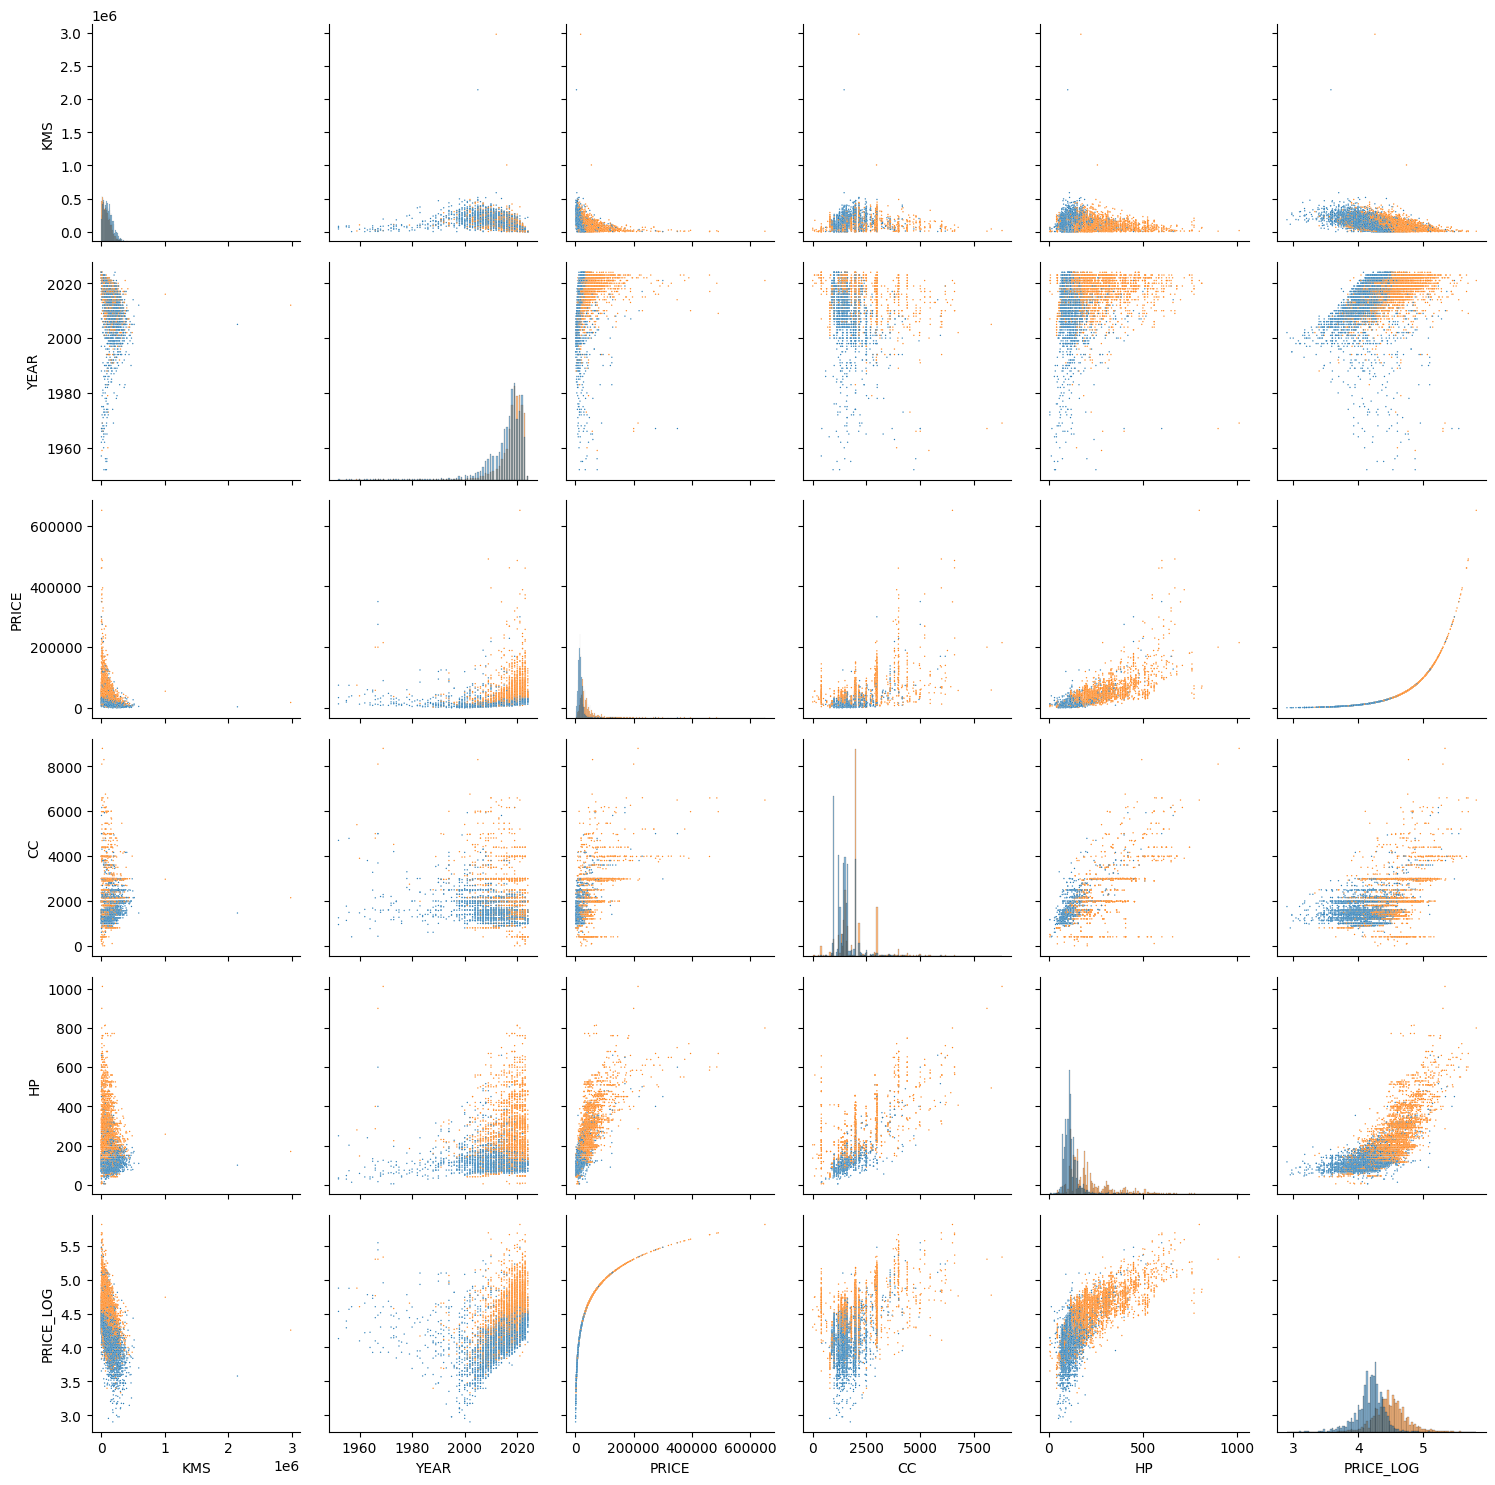

In [23]:
# Show a grid plot of numerical data
g = sns.PairGrid(df, hue='GEAR')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot, s=1)
#g.add_legend()